In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults
[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults


In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


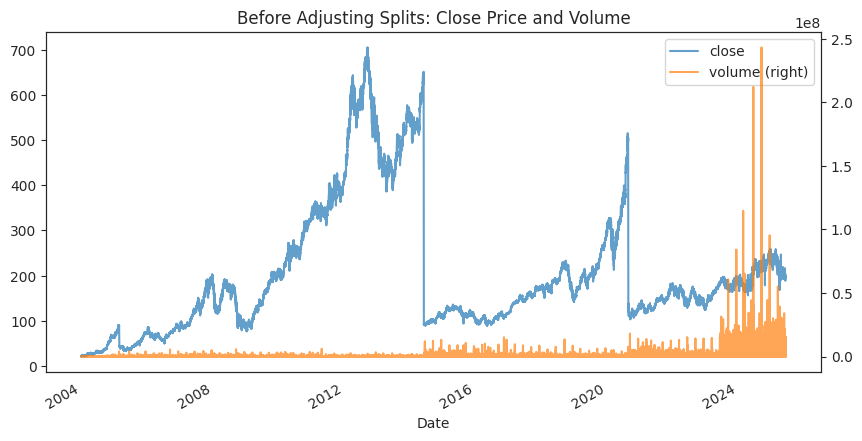

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


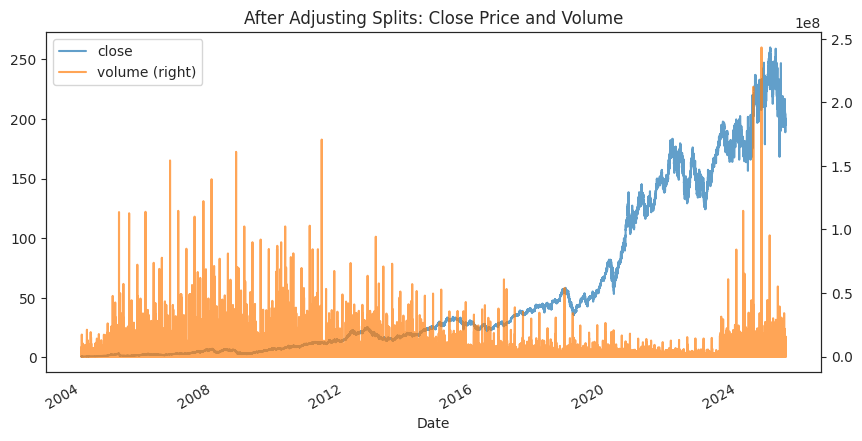

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile,
    smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',

        # — Trade-ID parameters —
        min_prof_thr             = min_prof_thr,            # profit % threshold (profit_pc ≥ min_prof_thr),  
                                                             # e.g. 0.5 → require at least 0.5% gain  
        max_down_prop            = max_down_prop,           # max retracement **fraction** of that profit range before exit,  
                                                             # e.g. 0.2 → allow up to 20% retracement of your gain  
        gain_tightening_factor   = gain_tightening_factor,  # dimensionless factor that tightens max_down_prop per %-gain,  
                                                             # applied as base/(1 + factor×gain%)  
        merging_retracement_thr  = merging_retracement_thr, # intermediate retracement **ratio** to merge two trades,  
                                                             # e.g. 0.3 → allow up to a 30% pullback of trade1’s range  
        merging_time_gap_thr     = merging_time_gap_thr,    # time-gap **ratio** to merge two trades,  
                                                             # gap_sec/(duration1+duration2), dimensionless  
    
        # — Continuous-signal parameters —
        pre_entry_decay          = pre_entry_decay,         # per-minute decay rate on pre-entry signal (0–1),  
                                                             # lower≈0.01→slow fade, higher≈0.1→fast fade  
        short_penal_decay        = short_penal_decay,       # exponent penalty on short-trade durations,  
                                                             # >1 amplifies suppression of very short signals  
    
        # — Final-trigger parameters —
        trailing_stop_pct        = trailing_stop_pct,       # trailing-stop distance **percent**,  
                                                             # internally divided by 100,  
                                                             # e.g. 0.5 → 0.5% stop loss  
        buy_threshold            = buy_threshold,           # normalized signal threshold ∈[0,1] to enter trade,  
                                                             # e.g. 0.5 → require 50% signal  
        top_percentile           = top_percentile,           # percentile **percent** to cap signal at 1.0,  
                                                             # e.g. 1.0 → top 1% of raw signals become 1.0  
        smoothing_window         = smoothing_window
    )


    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.05), # increasing min to 0.03, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.6),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 3, 9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.2, 0.6),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 2, 5),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.03, 0.09), # decreasing max to 0.05, to avoid too fast trading
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 3, 6),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.7), # increasing min to 0.03, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.3, 0.6),
        "top_percentile"          : trial.suggest_float("top_percentile", 3, 5),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [3])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-02 12:26:54,546] A new study created in RDB with name: no-name-f4857980-bd5c-4b7e-96e2-7d692c7da58a


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.57day/s]
[I 2025-09-02 12:30:00,232] Trial 0 finished with value: 0.3386737037037037 and parameters: {'min_prof_thr': 0.027332618481079554, 'max_down_prop': 0.4617611691161221, 'gain_tightening_factor': 5.022210777077697, 'merging_retracement_thr': 0.4570308310047902, 'merging_time_gap_thr': 3.230731445287308, 'pre_entry_decay': 0.043233438901601653, 'short_penal_decay': 5.283139516418911, 'trailing_stop_pct': 0.5108563472857908, 'buy_threshold': 0.5537659309841029, 'top_percentile': 3.437435441153877, 'smoothing_window': 3}. Best is trial 0 with value: 0.3386737037037037.


→ Total return across 5400 trading days: $1828.84
→ Avg daily return (all days)          : $0.3387
→ Total trades                          : 12979
→ Avg return per trade                  : $0.1409



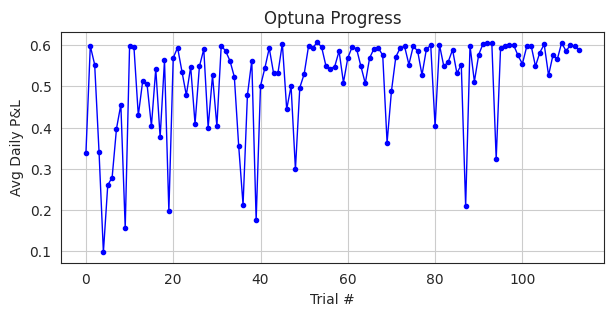

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.47day/s]
[I 2025-09-02 12:33:04,713] Trial 1 finished with value: 0.5975975925925926 and parameters: {'min_prof_thr': 0.014854513430978456, 'max_down_prop': 0.2191853007594797, 'gain_tightening_factor': 3.3360542103077195, 'merging_retracement_thr': 0.5919815399743924, 'merging_time_gap_thr': 3.216120519358623, 'pre_entry_decay': 0.05250425686716923, 'short_penal_decay': 4.838565691475399, 'trailing_stop_pct': 0.048206661246998926, 'buy_threshold': 0.5184327067491684, 'top_percentile': 4.39320100970824, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3227.03
→ Avg daily return (all days)          : $0.5976
→ Total trades                          : 30578
→ Avg return per trade                  : $0.1055

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.11day/s]
[I 2025-09-02 12:36:09,421] Trial 2 finished with value: 0.5524425925925927 and parameters: {'min_prof_thr': 0.03765870412886784, 'max_down_prop': 0.5704912875664561, 'gain_tightening_factor': 6.199178179801154, 'merging_retracement_thr': 0.2136263376792553, 'merging_time_gap_thr': 3.526705285573357, 'pre_entry_decay': 0.031774612585031746, 'short_penal_decay': 3.7474600678279737, 'trailing_stop_pct': 0.04649783312650187, 'buy_threshold': 0.3654841343142263, 'top_percentile': 3.7051598863483024, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2983.19
→ Avg daily return (all days)          : $0.5524
→ Total trades                          : 33006
→ Avg return per trade                  : $0.0904

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.10day/s]
[I 2025-09-02 12:39:12,167] Trial 3 finished with value: 0.3413427777777778 and parameters: {'min_prof_thr': 0.030735627772497706, 'max_down_prop': 0.31230193629704284, 'gain_tightening_factor': 5.732657437234015, 'merging_retracement_thr': 0.4711094110435077, 'merging_time_gap_thr': 2.710861833365442, 'pre_entry_decay': 0.032738872832904824, 'short_penal_decay': 4.362526346979793, 'trailing_stop_pct': 0.45869802451404307, 'buy_threshold': 0.4731690415311506, 'top_percentile': 3.8721191107904858, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $1843.25
→ Avg daily return (all days)          : $0.3413
→ Total trades                          : 14669
→ Avg return per trade                  : $0.1257

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.00day/s]
[I 2025-09-02 12:42:15,630] Trial 4 finished with value: 0.09794796296296296 and parameters: {'min_prof_thr': 0.04566253157274278, 'max_down_prop': 0.4747990476170182, 'gain_tightening_factor': 4.725421027084938, 'merging_retracement_thr': 0.5529351883160613, 'merging_time_gap_thr': 2.539232883092382, 'pre_entry_decay': 0.08324533358939656, 'short_penal_decay': 3.4041928601437474, 'trailing_stop_pct': 0.6868507765984291, 'buy_threshold': 0.33354352095214945, 'top_percentile': 3.71935488822779, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $528.92
→ Avg daily return (all days)          : $0.0979
→ Total trades                          : 14474
→ Avg return per trade                  : $0.0365

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.73day/s]
[I 2025-09-02 12:45:34,036] Trial 5 finished with value: 0.26066759259259265 and parameters: {'min_prof_thr': 0.02958651093593078, 'max_down_prop': 0.165604035570823, 'gain_tightening_factor': 6.45587396219536, 'merging_retracement_thr': 0.23609100332978714, 'merging_time_gap_thr': 2.917588361059156, 'pre_entry_decay': 0.06091254877457994, 'short_penal_decay': 3.429221190130665, 'trailing_stop_pct': 0.5336059932520889, 'buy_threshold': 0.4637093917375087, 'top_percentile': 3.6555195576379926, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $1407.61
→ Avg daily return (all days)          : $0.2607
→ Total trades                          : 15815
→ Avg return per trade                  : $0.0890

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.22day/s]
[I 2025-09-02 12:48:42,188] Trial 6 finished with value: 0.2788735185185185 and parameters: {'min_prof_thr': 0.02307290324269716, 'max_down_prop': 0.5933837814314937, 'gain_tightening_factor': 8.760237262803788, 'merging_retracement_thr': 0.24161803953914773, 'merging_time_gap_thr': 3.9891432715393087, 'pre_entry_decay': 0.04804419859385966, 'short_penal_decay': 4.908465376531856, 'trailing_stop_pct': 0.6681173542891405, 'buy_threshold': 0.5422987237857415, 'top_percentile': 4.174905996272629, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $1505.92
→ Avg daily return (all days)          : $0.2789
→ Total trades                          : 11865
→ Avg return per trade                  : $0.1269

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.24day/s]
[I 2025-09-02 12:52:03,096] Trial 7 finished with value: 0.3971925925925926 and parameters: {'min_prof_thr': 0.022991041316611498, 'max_down_prop': 0.13614875626308706, 'gain_tightening_factor': 6.039919996312729, 'merging_retracement_thr': 0.28688252217008786, 'merging_time_gap_thr': 3.3770486138289435, 'pre_entry_decay': 0.040513843434036786, 'short_penal_decay': 5.268012818960688, 'trailing_stop_pct': 0.39183517541892465, 'buy_threshold': 0.5633301340623602, 'top_percentile': 4.141163335470611, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2144.84
→ Avg daily return (all days)          : $0.3972
→ Total trades                          : 14530
→ Avg return per trade                  : $0.1476

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.70day/s]
[I 2025-09-02 12:55:11,356] Trial 8 finished with value: 0.4555683333333334 and parameters: {'min_prof_thr': 0.034183122260739184, 'max_down_prop': 0.5326328713473165, 'gain_tightening_factor': 8.860757017849345, 'merging_retracement_thr': 0.5308679090795962, 'merging_time_gap_thr': 3.0911344889497117, 'pre_entry_decay': 0.04274271515359828, 'short_penal_decay': 5.746340380547847, 'trailing_stop_pct': 0.26149870706306355, 'buy_threshold': 0.5415219743223683, 'top_percentile': 4.462726945166537, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2460.07
→ Avg daily return (all days)          : $0.4556
→ Total trades                          : 19045
→ Avg return per trade                  : $0.1292

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.35day/s]
[I 2025-09-02 12:58:24,658] Trial 9 finished with value: 0.1566488888888889 and parameters: {'min_prof_thr': 0.022277217873265108, 'max_down_prop': 0.30020687898502807, 'gain_tightening_factor': 6.904958858126522, 'merging_retracement_thr': 0.47970638687447126, 'merging_time_gap_thr': 4.692164787363904, 'pre_entry_decay': 0.0756859079629569, 'short_penal_decay': 4.256398988562234, 'trailing_stop_pct': 0.6502352564326251, 'buy_threshold': 0.33140946100594115, 'top_percentile': 3.519149355776623, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $845.90
→ Avg daily return (all days)          : $0.1566
→ Total trades                          : 14581
→ Avg return per trade                  : $0.0580

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.36day/s]
[I 2025-09-02 13:01:31,617] Trial 10 finished with value: 0.5973253703703704 and parameters: {'min_prof_thr': 0.01147661846058426, 'max_down_prop': 0.18348857009192396, 'gain_tightening_factor': 3.1927228713234337, 'merging_retracement_thr': 0.3539414088349748, 'merging_time_gap_thr': 2.1811420693281045, 'pre_entry_decay': 0.061611219951835855, 'short_penal_decay': 5.939982309233481, 'trailing_stop_pct': 0.038382025501193656, 'buy_threshold': 0.39222762765097763, 'top_percentile': 4.893207311702808, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3225.56
→ Avg daily return (all days)          : $0.5973
→ Total trades                          : 38025
→ Avg return per trade                  : $0.0848

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.33day/s]
[I 2025-09-02 13:04:43,602] Trial 11 finished with value: 0.5947383333333334 and parameters: {'min_prof_thr': 0.010444775498030023, 'max_down_prop': 0.22050484864923048, 'gain_tightening_factor': 3.12617307103237, 'merging_retracement_thr': 0.3512870687238114, 'merging_time_gap_thr': 2.177564105308872, 'pre_entry_decay': 0.06060493546326773, 'short_penal_decay': 5.8482412664917405, 'trailing_stop_pct': 0.0508877961833476, 'buy_threshold': 0.40463496447716574, 'top_percentile': 4.987019904436105, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3211.59
→ Avg daily return (all days)          : $0.5947
→ Total trades                          : 36581
→ Avg return per trade                  : $0.0878

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.39day/s]
[I 2025-09-02 13:07:56,768] Trial 12 finished with value: 0.42931814814814817 and parameters: {'min_prof_thr': 0.011187698629306159, 'max_down_prop': 0.23182308961642045, 'gain_tightening_factor': 3.045993303635065, 'merging_retracement_thr': 0.38117568154891734, 'merging_time_gap_thr': 2.0371941075365188, 'pre_entry_decay': 0.07032141023142138, 'short_penal_decay': 4.773709844907342, 'trailing_stop_pct': 0.1900750606283653, 'buy_threshold': 0.40968160216289823, 'top_percentile': 4.805741736334837, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2318.32
→ Avg daily return (all days)          : $0.4293
→ Total trades                          : 31547
→ Avg return per trade                  : $0.0735

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.89day/s]
[I 2025-09-02 13:11:11,139] Trial 13 finished with value: 0.512412962962963 and parameters: {'min_prof_thr': 0.016493329992160355, 'max_down_prop': 0.10051308072116452, 'gain_tightening_factor': 4.032433205569006, 'merging_retracement_thr': 0.5864326740785394, 'merging_time_gap_thr': 3.8891612787260756, 'pre_entry_decay': 0.0538177049206044, 'short_penal_decay': 5.977382183662096, 'trailing_stop_pct': 0.17302634309885212, 'buy_threshold': 0.5081717824164392, 'top_percentile': 4.5881030466620425, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2767.03
→ Avg daily return (all days)          : $0.5124
→ Total trades                          : 24920
→ Avg return per trade                  : $0.1110

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.12day/s]
[I 2025-09-02 13:14:26,552] Trial 14 finished with value: 0.5053788888888888 and parameters: {'min_prof_thr': 0.01704708142746293, 'max_down_prop': 0.23434762520002334, 'gain_tightening_factor': 3.955636057141599, 'merging_retracement_thr': 0.32173717268481794, 'merging_time_gap_thr': 2.4584921702434173, 'pre_entry_decay': 0.06899892079857535, 'short_penal_decay': 5.361292987340536, 'trailing_stop_pct': 0.13807662274728844, 'buy_threshold': 0.4203918506842178, 'top_percentile': 4.389793868260678, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2729.05
→ Avg daily return (all days)          : $0.5054
→ Total trades                          : 31865
→ Avg return per trade                  : $0.0856

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.62day/s]
[I 2025-09-02 13:17:49,771] Trial 15 finished with value: 0.40353222222222224 and parameters: {'min_prof_thr': 0.01581637260464609, 'max_down_prop': 0.3833877251740876, 'gain_tightening_factor': 3.9390859265068685, 'merging_retracement_thr': 0.4217890274498634, 'merging_time_gap_thr': 4.710536165754207, 'pre_entry_decay': 0.05282864944011623, 'short_penal_decay': 4.003029835513472, 'trailing_stop_pct': 0.28707908064426474, 'buy_threshold': 0.5002102411661076, 'top_percentile': 4.729001969312241, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2179.07
→ Avg daily return (all days)          : $0.4035
→ Total trades                          : 22497
→ Avg return per trade                  : $0.0969

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.71day/s]
[I 2025-09-02 13:21:06,100] Trial 16 finished with value: 0.5421153703703703 and parameters: {'min_prof_thr': 0.013798025364537773, 'max_down_prop': 0.3789052208386253, 'gain_tightening_factor': 7.286895897426412, 'merging_retracement_thr': 0.4070028183697412, 'merging_time_gap_thr': 4.264075895572565, 'pre_entry_decay': 0.06538894833351021, 'short_penal_decay': 3.0307662737758863, 'trailing_stop_pct': 0.11130546333842029, 'buy_threshold': 0.5876832771327872, 'top_percentile': 4.995171913926284, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2927.42
→ Avg daily return (all days)          : $0.5421
→ Total trades                          : 30915
→ Avg return per trade                  : $0.0947

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.06day/s]
[I 2025-09-02 13:24:23,790] Trial 17 finished with value: 0.3764307407407408 and parameters: {'min_prof_thr': 0.01913216738247669, 'max_down_prop': 0.17850958190836969, 'gain_tightening_factor': 4.899924044651016, 'merging_retracement_thr': 0.3039773900348133, 'merging_time_gap_thr': 3.6523276420700075, 'pre_entry_decay': 0.05437710252155124, 'short_penal_decay': 4.89118080752566, 'trailing_stop_pct': 0.2635818786377464, 'buy_threshold': 0.301998449655054, 'top_percentile': 3.0135719002659602, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2032.73
→ Avg daily return (all days)          : $0.3764
→ Total trades                          : 25055
→ Avg return per trade                  : $0.0811

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.45day/s]
[I 2025-09-02 13:27:15,671] Trial 18 finished with value: 0.562667037037037 and parameters: {'min_prof_thr': 0.04319958311294218, 'max_down_prop': 0.2916309447236917, 'gain_tightening_factor': 3.6750313562595207, 'merging_retracement_thr': 0.5131412532736941, 'merging_time_gap_thr': 2.303808988552358, 'pre_entry_decay': 0.08977216214165346, 'short_penal_decay': 5.493123181571008, 'trailing_stop_pct': 0.035618891095058725, 'buy_threshold': 0.4328215373425404, 'top_percentile': 4.337642855054617, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3038.40
→ Avg daily return (all days)          : $0.5627
→ Total trades                          : 41543
→ Avg return per trade                  : $0.0731

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.85day/s]
[I 2025-09-02 13:30:09,282] Trial 19 finished with value: 0.19697777777777778 and parameters: {'min_prof_thr': 0.04973368788406027, 'max_down_prop': 0.25546191446152067, 'gain_tightening_factor': 4.491861762844214, 'merging_retracement_thr': 0.593915337151105, 'merging_time_gap_thr': 2.8078403037304307, 'pre_entry_decay': 0.07842610686508739, 'short_penal_decay': 4.616276119258733, 'trailing_stop_pct': 0.34522985503750775, 'buy_threshold': 0.3779122661057722, 'top_percentile': 4.658047711587823, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $1063.68
→ Avg daily return (all days)          : $0.1970
→ Total trades                          : 25087
→ Avg return per trade                  : $0.0424

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.03day/s]
[I 2025-09-02 13:33:19,190] Trial 20 finished with value: 0.5687837037037038 and parameters: {'min_prof_thr': 0.010102972301670588, 'max_down_prop': 0.17755171919355656, 'gain_tightening_factor': 7.899235980550463, 'merging_retracement_thr': 0.36951355006670517, 'merging_time_gap_thr': 4.357360560235096, 'pre_entry_decay': 0.047613500170220764, 'short_penal_decay': 4.945018641639443, 'trailing_stop_pct': 0.10933461308017026, 'buy_threshold': 0.49651670058501374, 'top_percentile': 4.096565424592783, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3071.43
→ Avg daily return (all days)          : $0.5688
→ Total trades                          : 25408
→ Avg return per trade                  : $0.1209

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.00day/s]
[I 2025-09-02 13:36:27,531] Trial 21 finished with value: 0.593542037037037 and parameters: {'min_prof_thr': 0.010041609497030205, 'max_down_prop': 0.2188119436919418, 'gain_tightening_factor': 3.004723057015173, 'merging_retracement_thr': 0.3515695020780469, 'merging_time_gap_thr': 2.0241248220378854, 'pre_entry_decay': 0.06032618713214945, 'short_penal_decay': 5.82194156800786, 'trailing_stop_pct': 0.041172417683434305, 'buy_threshold': 0.38609772305881646, 'top_percentile': 4.923578633072434, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3205.13
→ Avg daily return (all days)          : $0.5935
→ Total trades                          : 38255
→ Avg return per trade                  : $0.0838

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.14day/s]
[I 2025-09-02 13:39:25,072] Trial 22 finished with value: 0.5355214814814814 and parameters: {'min_prof_thr': 0.013925886302362408, 'max_down_prop': 0.11390462170572312, 'gain_tightening_factor': 3.4193777875047644, 'merging_retracement_thr': 0.33565539705759834, 'merging_time_gap_thr': 2.289287967133852, 'pre_entry_decay': 0.06497499778535497, 'short_penal_decay': 5.63003982620368, 'trailing_stop_pct': 0.09944359651194312, 'buy_threshold': 0.3967016465208587, 'top_percentile': 4.846365511996438, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2891.82
→ Avg daily return (all days)          : $0.5355
→ Total trades                          : 35020
→ Avg return per trade                  : $0.0826

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.44day/s]
[I 2025-09-02 13:42:22,173] Trial 23 finished with value: 0.4783266666666667 and parameters: {'min_prof_thr': 0.019938772530616256, 'max_down_prop': 0.20823277127218828, 'gain_tightening_factor': 5.42227919924804, 'merging_retracement_thr': 0.27169137268834087, 'merging_time_gap_thr': 2.2782419551273887, 'pre_entry_decay': 0.056003416683466256, 'short_penal_decay': 5.9518657765013945, 'trailing_stop_pct': 0.17925964415380696, 'buy_threshold': 0.441817351612704, 'top_percentile': 4.567387661824254, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2582.96
→ Avg daily return (all days)          : $0.4783
→ Total trades                          : 25571
→ Avg return per trade                  : $0.1010

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.97day/s]
[I 2025-09-02 13:45:17,239] Trial 24 finished with value: 0.5470153703703703 and parameters: {'min_prof_thr': 0.013011702879094818, 'max_down_prop': 0.2701871583706906, 'gain_tightening_factor': 3.332263047330973, 'merging_retracement_thr': 0.4193876465154401, 'merging_time_gap_thr': 3.0151904166563273, 'pre_entry_decay': 0.05937642958091686, 'short_penal_decay': 5.132188750959248, 'trailing_stop_pct': 0.07711436371378913, 'buy_threshold': 0.36487674208768445, 'top_percentile': 4.985490793519851, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2953.88
→ Avg daily return (all days)          : $0.5470
→ Total trades                          : 39126
→ Avg return per trade                  : $0.0755

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.55day/s]
[I 2025-09-02 13:48:11,665] Trial 25 finished with value: 0.4089151851851852 and parameters: {'min_prof_thr': 0.02637255298006493, 'max_down_prop': 0.36184972572732355, 'gain_tightening_factor': 4.382900610785855, 'merging_retracement_thr': 0.44366025350645283, 'merging_time_gap_thr': 2.479746433287151, 'pre_entry_decay': 0.07289347187886214, 'short_penal_decay': 5.510423630706929, 'trailing_stop_pct': 0.21418068734239287, 'buy_threshold': 0.4463711036483766, 'top_percentile': 4.7426446882137325, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2208.14
→ Avg daily return (all days)          : $0.4089
→ Total trades                          : 28720
→ Avg return per trade                  : $0.0769

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.76day/s]
[I 2025-09-02 13:51:05,716] Trial 26 finished with value: 0.5478244444444446 and parameters: {'min_prof_thr': 0.018094715720512224, 'max_down_prop': 0.1501214002375986, 'gain_tightening_factor': 3.496805008416982, 'merging_retracement_thr': 0.38039431383174244, 'merging_time_gap_thr': 2.7443743984727798, 'pre_entry_decay': 0.04861757139358549, 'short_penal_decay': 5.696822222062113, 'trailing_stop_pct': 0.13381859193125556, 'buy_threshold': 0.4747653511519031, 'top_percentile': 4.292636897596595, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2958.25
→ Avg daily return (all days)          : $0.5478
→ Total trades                          : 25130
→ Avg return per trade                  : $0.1177

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.71day/s]
[I 2025-09-02 13:54:14,932] Trial 27 finished with value: 0.5897027777777778 and parameters: {'min_prof_thr': 0.013128889746609348, 'max_down_prop': 0.193393364783252, 'gain_tightening_factor': 4.347491850223706, 'merging_retracement_thr': 0.34370706976613524, 'merging_time_gap_thr': 2.0012852101388425, 'pre_entry_decay': 0.06447708615828082, 'short_penal_decay': 5.991153397894829, 'trailing_stop_pct': 0.0716190943282327, 'buy_threshold': 0.5217975874648098, 'top_percentile': 4.510541314450101, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $3184.39
→ Avg daily return (all days)          : $0.5897
→ Total trades                          : 28462
→ Avg return per trade                  : $0.1119

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.05day/s]
[I 2025-09-02 13:57:16,021] Trial 28 finished with value: 0.39983296296296295 and parameters: {'min_prof_thr': 0.015234666633911738, 'max_down_prop': 0.33885560671360954, 'gain_tightening_factor': 3.0256058104237993, 'merging_retracement_thr': 0.5073345996268347, 'merging_time_gap_thr': 3.273981173762452, 'pre_entry_decay': 0.03701662654973945, 'short_penal_decay': 4.605747456727376, 'trailing_stop_pct': 0.22200115955814126, 'buy_threshold': 0.34159479382507957, 'top_percentile': 4.847032675633821, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2159.10
→ Avg daily return (all days)          : $0.3998
→ Total trades                          : 25844
→ Avg return per trade                  : $0.0835

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.29day/s]
[I 2025-09-02 14:00:16,455] Trial 29 finished with value: 0.526140925925926 and parameters: {'min_prof_thr': 0.020646532224114247, 'max_down_prop': 0.26277938040198145, 'gain_tightening_factor': 5.443148913073008, 'merging_retracement_thr': 0.44562174969677926, 'merging_time_gap_thr': 3.188722146717037, 'pre_entry_decay': 0.050245673017430895, 'short_penal_decay': 5.087816672610613, 'trailing_stop_pct': 0.14736423074672153, 'buy_threshold': 0.4168444723815447, 'top_percentile': 3.927992317489005, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2841.16
→ Avg daily return (all days)          : $0.5261
→ Total trades                          : 28042
→ Avg return per trade                  : $0.1013

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.46day/s]
[I 2025-09-02 14:03:12,552] Trial 30 finished with value: 0.4034709259259259 and parameters: {'min_prof_thr': 0.024887720908964246, 'max_down_prop': 0.42227981850058194, 'gain_tightening_factor': 3.752861650497021, 'merging_retracement_thr': 0.2733124744015633, 'merging_time_gap_thr': 2.591158304402398, 'pre_entry_decay': 0.05914808414101327, 'short_penal_decay': 5.323913869514815, 'trailing_stop_pct': 0.32082407490121656, 'buy_threshold': 0.5852411244472349, 'top_percentile': 4.6638752393208724, 'smoothing_window': 3}. Best is trial 1 with value: 0.5975975925925926.


→ Total return across 5400 trading days: $2178.74
→ Avg daily return (all days)          : $0.4035
→ Total trades                          : 18450
→ Avg return per trade                  : $0.1181

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.86day/s]
[I 2025-09-02 14:06:18,367] Trial 31 finished with value: 0.5985125925925926 and parameters: {'min_prof_thr': 0.010238872441640965, 'max_down_prop': 0.2380171693850246, 'gain_tightening_factor': 3.039047510612203, 'merging_retracement_thr': 0.3572033549084904, 'merging_time_gap_thr': 2.2013535558994186, 'pre_entry_decay': 0.062274048042569016, 'short_penal_decay': 5.764756235122663, 'trailing_stop_pct': 0.04162295913901093, 'buy_threshold': 0.3953890442643378, 'top_percentile': 4.890871318814762, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $3231.97
→ Avg daily return (all days)          : $0.5985
→ Total trades                          : 38147
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.42day/s]
[I 2025-09-02 14:09:30,415] Trial 32 finished with value: 0.5853137037037036 and parameters: {'min_prof_thr': 0.013020168793637998, 'max_down_prop': 0.13621785101782236, 'gain_tightening_factor': 3.368812344932511, 'merging_retracement_thr': 0.3625319484073797, 'merging_time_gap_thr': 2.2072242979593537, 'pre_entry_decay': 0.0671311065874246, 'short_penal_decay': 5.501329711651186, 'trailing_stop_pct': 0.0381364297661387, 'buy_threshold': 0.36396974063133775, 'top_percentile': 4.830225355932552, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $3160.69
→ Avg daily return (all days)          : $0.5853
→ Total trades                          : 42322
→ Avg return per trade                  : $0.0747

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.38day/s]
[I 2025-09-02 14:12:44,617] Trial 33 finished with value: 0.5616122222222223 and parameters: {'min_prof_thr': 0.011479846828085493, 'max_down_prop': 0.20192952642102552, 'gain_tightening_factor': 4.14623685987568, 'merging_retracement_thr': 0.3049636755359025, 'merging_time_gap_thr': 2.14823790425423, 'pre_entry_decay': 0.05710167527290784, 'short_penal_decay': 5.8163485016201335, 'trailing_stop_pct': 0.07894023888306567, 'buy_threshold': 0.3977213195405522, 'top_percentile': 4.993414116736671, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $3032.71
→ Avg daily return (all days)          : $0.5616
→ Total trades                          : 33932
→ Avg return per trade                  : $0.0894

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.41day/s]
[I 2025-09-02 14:15:57,230] Trial 34 finished with value: 0.522737962962963 and parameters: {'min_prof_thr': 0.015688966540568137, 'max_down_prop': 0.32013277878869784, 'gain_tightening_factor': 3.5956840581434855, 'merging_retracement_thr': 0.393755918811692, 'merging_time_gap_thr': 2.5832315047928818, 'pre_entry_decay': 0.06410924439328416, 'short_penal_decay': 4.158062728838563, 'trailing_stop_pct': 0.074679264062767, 'buy_threshold': 0.3510477609934447, 'top_percentile': 4.691721335010431, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $2822.79
→ Avg daily return (all days)          : $0.5227
→ Total trades                          : 42852
→ Avg return per trade                  : $0.0659

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.57day/s]
[I 2025-09-02 14:19:05,325] Trial 35 finished with value: 0.35521222222222226 and parameters: {'min_prof_thr': 0.01014561017424203, 'max_down_prop': 0.2474937519072009, 'gain_tightening_factor': 5.217041152443081, 'merging_retracement_thr': 0.32667988323154534, 'merging_time_gap_thr': 3.569037180887308, 'pre_entry_decay': 0.0620489326705409, 'short_penal_decay': 5.606878949791055, 'trailing_stop_pct': 0.41437620404197695, 'buy_threshold': 0.4662703465770315, 'top_percentile': 3.049719065849763, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $1918.15
→ Avg daily return (all days)          : $0.3552
→ Total trades                          : 16713
→ Avg return per trade                  : $0.1148

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.33day/s]
[I 2025-09-02 14:22:25,764] Trial 36 finished with value: 0.21282574074074073 and parameters: {'min_prof_thr': 0.037485180102602704, 'max_down_prop': 0.27869816602399666, 'gain_tightening_factor': 4.722192008847335, 'merging_retracement_thr': 0.4055789133636436, 'merging_time_gap_thr': 2.3730236900193082, 'pre_entry_decay': 0.06995327904723761, 'short_penal_decay': 5.138877263908263, 'trailing_stop_pct': 0.5413577085981507, 'buy_threshold': 0.423194564219972, 'top_percentile': 4.884798621856351, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $1149.26
→ Avg daily return (all days)          : $0.2128
→ Total trades                          : 16329
→ Avg return per trade                  : $0.0704

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.11day/s]
[I 2025-09-02 14:25:27,180] Trial 37 finished with value: 0.4782453703703703 and parameters: {'min_prof_thr': 0.0299473247791947, 'max_down_prop': 0.15520909826863336, 'gain_tightening_factor': 3.2807821489073747, 'merging_retracement_thr': 0.46996859032036487, 'merging_time_gap_thr': 4.9393990794947396, 'pre_entry_decay': 0.0512142840372878, 'short_penal_decay': 3.6457423238032773, 'trailing_stop_pct': 0.14893363272892235, 'buy_threshold': 0.4032517432965889, 'top_percentile': 4.439438903590206, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $2582.52
→ Avg daily return (all days)          : $0.4782
→ Total trades                          : 32284
→ Avg return per trade                  : $0.0800

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.75day/s]
[I 2025-09-02 14:28:35,863] Trial 38 finished with value: 0.5622112962962963 and parameters: {'min_prof_thr': 0.018582062630994815, 'max_down_prop': 0.19032439347912336, 'gain_tightening_factor': 3.7261001042298663, 'merging_retracement_thr': 0.23975249104560056, 'merging_time_gap_thr': 2.8755834142334384, 'pre_entry_decay': 0.04433141450858532, 'short_penal_decay': 5.8319863449162455, 'trailing_stop_pct': 0.03634902697849772, 'buy_threshold': 0.37912831669625585, 'top_percentile': 4.281685735347912, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $3035.94
→ Avg daily return (all days)          : $0.5622
→ Total trades                          : 32022
→ Avg return per trade                  : $0.0948

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.80day/s]
[I 2025-09-02 14:31:48,298] Trial 39 finished with value: 0.17569648148148148 and parameters: {'min_prof_thr': 0.012182472885445841, 'max_down_prop': 0.2229039157050219, 'gain_tightening_factor': 3.1606332238945734, 'merging_retracement_thr': 0.5632184322020648, 'merging_time_gap_thr': 2.6964999513511723, 'pre_entry_decay': 0.058362326839285585, 'short_penal_decay': 5.419177662984335, 'trailing_stop_pct': 0.5894472389112363, 'buy_threshold': 0.31070415759066494, 'top_percentile': 4.574347187682883, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $948.76
→ Avg daily return (all days)          : $0.1757
→ Total trades                          : 14771
→ Avg return per trade                  : $0.0642

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.80day/s]
[I 2025-09-02 14:34:57,491] Trial 40 finished with value: 0.500894074074074 and parameters: {'min_prof_thr': 0.03286614657841998, 'max_down_prop': 0.5099241669400847, 'gain_tightening_factor': 6.361696580147842, 'merging_retracement_thr': 0.3107135896917143, 'merging_time_gap_thr': 3.810265013600031, 'pre_entry_decay': 0.0747369044232254, 'short_penal_decay': 4.431499976438133, 'trailing_stop_pct': 0.11547247847269901, 'buy_threshold': 0.4577452131474057, 'top_percentile': 4.760285790325513, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $2704.83
→ Avg daily return (all days)          : $0.5009
→ Total trades                          : 35468
→ Avg return per trade                  : $0.0763

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.04day/s]
[I 2025-09-02 14:38:18,914] Trial 41 finished with value: 0.5441664814814814 and parameters: {'min_prof_thr': 0.010130911327551603, 'max_down_prop': 0.2143003781437688, 'gain_tightening_factor': 3.0167631707221925, 'merging_retracement_thr': 0.20114262129317698, 'merging_time_gap_thr': 2.118152835386244, 'pre_entry_decay': 0.061849080291278766, 'short_penal_decay': 5.804800259237964, 'trailing_stop_pct': 0.0614949350327217, 'buy_threshold': 0.3880394618676978, 'top_percentile': 4.896126318361029, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $2938.50
→ Avg daily return (all days)          : $0.5442
→ Total trades                          : 35773
→ Avg return per trade                  : $0.0821

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.59day/s]
[I 2025-09-02 14:41:36,458] Trial 42 finished with value: 0.5923785185185185 and parameters: {'min_prof_thr': 0.0143221641123037, 'max_down_prop': 0.3244711662804009, 'gain_tightening_factor': 3.498273400774411, 'merging_retracement_thr': 0.35614819418307014, 'merging_time_gap_thr': 2.0210711072630714, 'pre_entry_decay': 0.061040910168908655, 'short_penal_decay': 5.634616285408052, 'trailing_stop_pct': 0.036048920205431, 'buy_threshold': 0.3860887015942794, 'top_percentile': 4.929773360274088, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $3198.84
→ Avg daily return (all days)          : $0.5924
→ Total trades                          : 39511
→ Avg return per trade                  : $0.0810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:55<00:00, 30.70day/s]
[I 2025-09-02 14:44:58,376] Trial 43 finished with value: 0.5311744444444444 and parameters: {'min_prof_thr': 0.011914025590303641, 'max_down_prop': 0.23277124549747488, 'gain_tightening_factor': 3.872235680112182, 'merging_retracement_thr': 0.3470978451684302, 'merging_time_gap_thr': 2.4060693525569454, 'pre_entry_decay': 0.055685121349349206, 'short_penal_decay': 5.872732136105277, 'trailing_stop_pct': 0.09530333738030677, 'buy_threshold': 0.35335926763039305, 'top_percentile': 4.789486991257557, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $2868.34
→ Avg daily return (all days)          : $0.5312
→ Total trades                          : 34776
→ Avg return per trade                  : $0.0825

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.20day/s]
[I 2025-09-02 14:48:20,659] Trial 44 finished with value: 0.5321942592592593 and parameters: {'min_prof_thr': 0.016708174353777656, 'max_down_prop': 0.1300498732213212, 'gain_tightening_factor': 3.0251825758233157, 'merging_retracement_thr': 0.3783743325592814, 'merging_time_gap_thr': 2.229577915563799, 'pre_entry_decay': 0.0623589996745187, 'short_penal_decay': 5.2517166180878805, 'trailing_stop_pct': 0.063745421904472, 'buy_threshold': 0.3214746020968838, 'top_percentile': 4.930026783994708, 'smoothing_window': 3}. Best is trial 31 with value: 0.5985125925925926.


→ Total return across 5400 trading days: $2873.85
→ Avg daily return (all days)          : $0.5322
→ Total trades                          : 42464
→ Avg return per trade                  : $0.0677

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.65day/s]
[I 2025-09-02 14:51:30,435] Trial 45 finished with value: 0.603392037037037 and parameters: {'min_prof_thr': 0.011456334720060397, 'max_down_prop': 0.2924848958256459, 'gain_tightening_factor': 4.173602245000355, 'merging_retracement_thr': 0.2946931930268146, 'merging_time_gap_thr': 2.607365676141128, 'pre_entry_decay': 0.06649356853023025, 'short_penal_decay': 5.711977803688765, 'trailing_stop_pct': 0.030419330512624545, 'buy_threshold': 0.37301706848485516, 'top_percentile': 3.6994233230398907, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $3258.32
→ Avg daily return (all days)          : $0.6034
→ Total trades                          : 37449
→ Avg return per trade                  : $0.0870

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:57<00:00, 30.45day/s]
[I 2025-09-02 14:54:55,847] Trial 46 finished with value: 0.4442718518518519 and parameters: {'min_prof_thr': 0.0151014421407204, 'max_down_prop': 0.2971676208755431, 'gain_tightening_factor': 4.145390604448137, 'merging_retracement_thr': 0.27635207798659017, 'merging_time_gap_thr': 2.590499490118976, 'pre_entry_decay': 0.07864501720993694, 'short_penal_decay': 5.692707752114092, 'trailing_stop_pct': 0.2087735079259452, 'buy_threshold': 0.43641342114961346, 'top_percentile': 3.6720977698328796, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $2399.07
→ Avg daily return (all days)          : $0.4443
→ Total trades                          : 26785
→ Avg return per trade                  : $0.0896

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.77day/s]
[I 2025-09-02 14:57:59,700] Trial 47 finished with value: 0.500441851851852 and parameters: {'min_prof_thr': 0.021676198378149374, 'max_down_prop': 0.25105840700911036, 'gain_tightening_factor': 4.5496207010006255, 'merging_retracement_thr': 0.2931098173736216, 'merging_time_gap_thr': 3.0087552562452884, 'pre_entry_decay': 0.06673560810933828, 'short_penal_decay': 5.994072692092922, 'trailing_stop_pct': 0.16472674464626022, 'buy_threshold': 0.4838417083730198, 'top_percentile': 3.4610025623072893, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $2702.39
→ Avg daily return (all days)          : $0.5004
→ Total trades                          : 24009
→ Avg return per trade                  : $0.1126

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.50day/s]
[I 2025-09-02 15:00:58,267] Trial 48 finished with value: 0.29861166666666666 and parameters: {'min_prof_thr': 0.017680968363389105, 'max_down_prop': 0.16845769072230982, 'gain_tightening_factor': 4.012500822587655, 'merging_retracement_thr': 0.31826875147773, 'merging_time_gap_thr': 2.671608556439415, 'pre_entry_decay': 0.0723063704294061, 'short_penal_decay': 5.527187319724387, 'trailing_stop_pct': 0.451268693707859, 'buy_threshold': 0.4130456501189718, 'top_percentile': 3.3314686036590033, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $1612.50
→ Avg daily return (all days)          : $0.2986
→ Total trades                          : 17772
→ Avg return per trade                  : $0.0907

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.44day/s]
[I 2025-09-02 15:04:05,365] Trial 49 finished with value: 0.49663999999999997 and parameters: {'min_prof_thr': 0.011975874318106232, 'max_down_prop': 0.2819306241434188, 'gain_tightening_factor': 3.279583359432109, 'merging_retracement_thr': 0.26434112476282157, 'merging_time_gap_thr': 3.3823461187198642, 'pre_entry_decay': 0.06818123378826713, 'short_penal_decay': 3.870727005105614, 'trailing_stop_pct': 0.12045635060814965, 'buy_threshold': 0.3718130161350604, 'top_percentile': 3.797097904501904, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $2681.86
→ Avg daily return (all days)          : $0.4966
→ Total trades                          : 36827
→ Avg return per trade                  : $0.0728

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:50<00:00, 31.64day/s]
[I 2025-09-02 15:07:21,458] Trial 50 finished with value: 0.5295329629629629 and parameters: {'min_prof_thr': 0.014791840900707669, 'max_down_prop': 0.30964066548622904, 'gain_tightening_factor': 3.667377562958821, 'merging_retracement_thr': 0.22411172544530025, 'merging_time_gap_thr': 2.427415393686684, 'pre_entry_decay': 0.045156565764137464, 'short_penal_decay': 5.22089474185243, 'trailing_stop_pct': 0.09118272880371164, 'buy_threshold': 0.5556900011703172, 'top_percentile': 3.612312174037807, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $2859.48
→ Avg daily return (all days)          : $0.5295
→ Total trades                          : 20428
→ Avg return per trade                  : $0.1400

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:56<00:00, 30.53day/s]
[I 2025-09-02 15:10:46,925] Trial 51 finished with value: 0.5968240740740741 and parameters: {'min_prof_thr': 0.010424327030988372, 'max_down_prop': 0.23479262703298778, 'gain_tightening_factor': 3.251021826094857, 'merging_retracement_thr': 0.3546860159961935, 'merging_time_gap_thr': 2.102380118750503, 'pre_entry_decay': 0.05282027371765, 'short_penal_decay': 5.740638969326924, 'trailing_stop_pct': 0.03470554983637689, 'buy_threshold': 0.3898328497431026, 'top_percentile': 3.9337124420168874, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $3222.85
→ Avg daily return (all days)          : $0.5968
→ Total trades                          : 34125
→ Avg return per trade                  : $0.0944

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.18day/s]
[I 2025-09-02 15:13:59,690] Trial 52 finished with value: 0.5934088888888889 and parameters: {'min_prof_thr': 0.011534629417944395, 'max_down_prop': 0.23079710531229997, 'gain_tightening_factor': 3.3083402987667796, 'merging_retracement_thr': 0.3336619077395526, 'merging_time_gap_thr': 2.1692371170240694, 'pre_entry_decay': 0.05309640387507615, 'short_penal_decay': 5.711566604649315, 'trailing_stop_pct': 0.06012363390085552, 'buy_threshold': 0.4261364406463136, 'top_percentile': 4.00942073444132, 'smoothing_window': 3}. Best is trial 45 with value: 0.603392037037037.


→ Total return across 5400 trading days: $3204.41
→ Avg daily return (all days)          : $0.5934
→ Total trades                          : 30593
→ Avg return per trade                  : $0.1047

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.03day/s]
[I 2025-09-02 15:17:15,334] Trial 53 finished with value: 0.6066029629629629 and parameters: {'min_prof_thr': 0.013201793690311086, 'max_down_prop': 0.18450905423913064, 'gain_tightening_factor': 5.885088622091102, 'merging_retracement_thr': 0.42497856442650017, 'merging_time_gap_thr': 2.352886138908878, 'pre_entry_decay': 0.05710721853247531, 'short_penal_decay': 5.386582090038126, 'trailing_stop_pct': 0.053262180026285716, 'buy_threshold': 0.4028769523391876, 'top_percentile': 3.8648502287940367, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3275.66
→ Avg daily return (all days)          : $0.6066
→ Total trades                          : 34441
→ Avg return per trade                  : $0.0951

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.52day/s]
[I 2025-09-02 15:20:16,726] Trial 54 finished with value: 0.5947857407407408 and parameters: {'min_prof_thr': 0.013191635322054144, 'max_down_prop': 0.1805074562050864, 'gain_tightening_factor': 5.932833753749481, 'merging_retracement_thr': 0.563172055611061, 'merging_time_gap_thr': 2.3084312533258795, 'pre_entry_decay': 0.05683571880084701, 'short_penal_decay': 5.420315987639292, 'trailing_stop_pct': 0.03342423676550169, 'buy_threshold': 0.3532935269740903, 'top_percentile': 3.8203659790290807, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3211.84
→ Avg daily return (all days)          : $0.5948
→ Total trades                          : 40218
→ Avg return per trade                  : $0.0799

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.78day/s]
[I 2025-09-02 15:23:11,357] Trial 55 finished with value: 0.5488603703703703 and parameters: {'min_prof_thr': 0.0168080847876301, 'max_down_prop': 0.2530534383299201, 'gain_tightening_factor': 8.12713573841651, 'merging_retracement_thr': 0.4971353715125, 'merging_time_gap_thr': 2.1041959878501624, 'pre_entry_decay': 0.04178427025560039, 'short_penal_decay': 5.052486915318228, 'trailing_stop_pct': 0.09452692336127391, 'buy_threshold': 0.3357930589277366, 'top_percentile': 4.036724963189416, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2963.85
→ Avg daily return (all days)          : $0.5489
→ Total trades                          : 33121
→ Avg return per trade                  : $0.0895

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.60day/s]
[I 2025-09-02 15:26:23,912] Trial 56 finished with value: 0.5423381481481481 and parameters: {'min_prof_thr': 0.013625624237295623, 'max_down_prop': 0.1612766588946812, 'gain_tightening_factor': 7.565418758279924, 'merging_retracement_thr': 0.42224515503803073, 'merging_time_gap_thr': 2.519407094084355, 'pre_entry_decay': 0.05133253475651363, 'short_penal_decay': 4.790564222634994, 'trailing_stop_pct': 0.12208747584505683, 'buy_threshold': 0.3946915270990164, 'top_percentile': 3.903542468767093, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2928.63
→ Avg daily return (all days)          : $0.5423
→ Total trades                          : 30760
→ Avg return per trade                  : $0.0952

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.81day/s]
[I 2025-09-02 15:29:40,944] Trial 57 finished with value: 0.5476851851851853 and parameters: {'min_prof_thr': 0.01145463514254523, 'max_down_prop': 0.19788753003840331, 'gain_tightening_factor': 6.758492112034768, 'merging_retracement_thr': 0.2567668279673191, 'merging_time_gap_thr': 2.376035875468539, 'pre_entry_decay': 0.03921801764101874, 'short_penal_decay': 5.5858721776596365, 'trailing_stop_pct': 0.06207572301869205, 'buy_threshold': 0.5287166561934441, 'top_percentile': 4.182732379771388, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2957.50
→ Avg daily return (all days)          : $0.5477
→ Total trades                          : 22279
→ Avg return per trade                  : $0.1327

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.30day/s]
[I 2025-09-02 15:32:53,236] Trial 58 finished with value: 0.5850587037037037 and parameters: {'min_prof_thr': 0.01570454402248977, 'max_down_prop': 0.24553716057066113, 'gain_tightening_factor': 4.932683485946077, 'merging_retracement_thr': 0.5401871216737731, 'merging_time_gap_thr': 2.860766924458493, 'pre_entry_decay': 0.04717001996324906, 'short_penal_decay': 5.886136358816815, 'trailing_stop_pct': 0.08750296057765573, 'buy_threshold': 0.37135591475647084, 'top_percentile': 3.7365731901509713, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3159.32
→ Avg daily return (all days)          : $0.5851
→ Total trades                          : 31605
→ Avg return per trade                  : $0.1000

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.39day/s]
[I 2025-09-02 15:35:54,964] Trial 59 finished with value: 0.5089757407407407 and parameters: {'min_prof_thr': 0.01934568840888396, 'max_down_prop': 0.27115926456529577, 'gain_tightening_factor': 4.201885097985512, 'merging_retracement_thr': 0.3922874828786356, 'merging_time_gap_thr': 2.245898302717096, 'pre_entry_decay': 0.05442416926698638, 'short_penal_decay': 5.730987578684803, 'trailing_stop_pct': 0.15722037500249642, 'buy_threshold': 0.4075675874251778, 'top_percentile': 3.9547819135017277, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2748.47
→ Avg daily return (all days)          : $0.5090
→ Total trades                          : 27540
→ Avg return per trade                  : $0.0998

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.38day/s]
[I 2025-09-02 15:38:54,053] Trial 60 finished with value: 0.5685220370370371 and parameters: {'min_prof_thr': 0.024236128546529827, 'max_down_prop': 0.10494095808983916, 'gain_tightening_factor': 3.8140803594573565, 'merging_retracement_thr': 0.3691708719317642, 'merging_time_gap_thr': 4.2684368968500515, 'pre_entry_decay': 0.04948069970851278, 'short_penal_decay': 5.383095748738734, 'trailing_stop_pct': 0.05023634696201168, 'buy_threshold': 0.5720024258189375, 'top_percentile': 4.118089546108811, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3070.02
→ Avg daily return (all days)          : $0.5685
→ Total trades                          : 24239
→ Avg return per trade                  : $0.1267

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.26day/s]
[I 2025-09-02 15:42:06,804] Trial 61 finished with value: 0.5952348148148149 and parameters: {'min_prof_thr': 0.012918636316104485, 'max_down_prop': 0.18140877092394805, 'gain_tightening_factor': 5.84441669649003, 'merging_retracement_thr': 0.5669518158622077, 'merging_time_gap_thr': 2.357821181418914, 'pre_entry_decay': 0.05739138933350592, 'short_penal_decay': 5.444178596895727, 'trailing_stop_pct': 0.032457614587082746, 'buy_threshold': 0.35243284463260066, 'top_percentile': 3.8273310818104838, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3214.27
→ Avg daily return (all days)          : $0.5952
→ Total trades                          : 40518
→ Avg return per trade                  : $0.0793

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.69day/s]
[I 2025-09-02 15:45:11,859] Trial 62 finished with value: 0.59095 and parameters: {'min_prof_thr': 0.014353102409432402, 'max_down_prop': 0.14077528736667438, 'gain_tightening_factor': 5.585874999739271, 'merging_retracement_thr': 0.5874892915352269, 'merging_time_gap_thr': 2.4896500960107217, 'pre_entry_decay': 0.05850165664298926, 'short_penal_decay': 4.951499806909078, 'trailing_stop_pct': 0.056847529241907925, 'buy_threshold': 0.36162268000349096, 'top_percentile': 3.560205779484047, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3191.13
→ Avg daily return (all days)          : $0.5909
→ Total trades                          : 38425
→ Avg return per trade                  : $0.0830

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.05day/s]
[I 2025-09-02 15:48:14,421] Trial 63 finished with value: 0.5485038888888889 and parameters: {'min_prof_thr': 0.010979371167985724, 'max_down_prop': 0.20887335404812912, 'gain_tightening_factor': 5.887179079686454, 'merging_retracement_thr': 0.5762452467598767, 'merging_time_gap_thr': 2.3641628615728187, 'pre_entry_decay': 0.06325076203733945, 'short_penal_decay': 5.569366328075409, 'trailing_stop_pct': 0.10653909125383423, 'buy_threshold': 0.3840202075767515, 'top_percentile': 3.8289521790990757, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2961.92
→ Avg daily return (all days)          : $0.5485
→ Total trades                          : 34275
→ Avg return per trade                  : $0.0864

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 35.02day/s]
[I 2025-09-02 15:51:17,881] Trial 64 finished with value: 0.506917962962963 and parameters: {'min_prof_thr': 0.012400640766120099, 'max_down_prop': 0.18207861762151117, 'gain_tightening_factor': 6.649720088058173, 'merging_retracement_thr': 0.5279673848456693, 'merging_time_gap_thr': 2.7485465594770138, 'pre_entry_decay': 0.05503303980590803, 'short_penal_decay': 5.899742738580083, 'trailing_stop_pct': 0.13093153652692646, 'buy_threshold': 0.3262475604259383, 'top_percentile': 3.729208989305418, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2737.36
→ Avg daily return (all days)          : $0.5069
→ Total trades                          : 33055
→ Avg return per trade                  : $0.0828

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.96day/s]
[I 2025-09-02 15:54:11,912] Trial 65 finished with value: 0.5684072222222222 and parameters: {'min_prof_thr': 0.013972795740108374, 'max_down_prop': 0.23541495113325944, 'gain_tightening_factor': 3.5440505017143478, 'merging_retracement_thr': 0.5472001793860971, 'merging_time_gap_thr': 2.0837451414916, 'pre_entry_decay': 0.052160480238238764, 'short_penal_decay': 5.43030947714343, 'trailing_stop_pct': 0.07605186682936299, 'buy_threshold': 0.34703849203979203, 'top_percentile': 4.2166992347950725, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3069.40
→ Avg daily return (all days)          : $0.5684
→ Total trades                          : 36778
→ Avg return per trade                  : $0.0835

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 33.99day/s]
[I 2025-09-02 15:57:11,908] Trial 66 finished with value: 0.5910866666666666 and parameters: {'min_prof_thr': 0.028047506233188278, 'max_down_prop': 0.12704353375920338, 'gain_tightening_factor': 5.120059903036049, 'merging_retracement_thr': 0.5994727421336581, 'merging_time_gap_thr': 2.300916613533032, 'pre_entry_decay': 0.06634862488550777, 'short_penal_decay': 5.287597478867331, 'trailing_stop_pct': 0.03497414183053763, 'buy_threshold': 0.39402871967235564, 'top_percentile': 3.9688659118870873, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3191.87
→ Avg daily return (all days)          : $0.5911
→ Total trades                          : 40086
→ Avg return per trade                  : $0.0796

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.52day/s]
[I 2025-09-02 16:00:18,047] Trial 67 finished with value: 0.5926718518518519 and parameters: {'min_prof_thr': 0.010949851642490613, 'max_down_prop': 0.16704890034407643, 'gain_tightening_factor': 5.676260370590063, 'merging_retracement_thr': 0.2962886481034129, 'merging_time_gap_thr': 2.198476133354116, 'pre_entry_decay': 0.05765071768124868, 'short_penal_decay': 5.7470272586291475, 'trailing_stop_pct': 0.030037778240881274, 'buy_threshold': 0.3720530928448894, 'top_percentile': 4.05585816786803, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3200.43
→ Avg daily return (all days)          : $0.5927
→ Total trades                          : 36367
→ Avg return per trade                  : $0.0880

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.65day/s]
[I 2025-09-02 16:03:28,370] Trial 68 finished with value: 0.5749792592592592 and parameters: {'min_prof_thr': 0.0165385525081825, 'max_down_prop': 0.21411754034078995, 'gain_tightening_factor': 6.368415832457, 'merging_retracement_thr': 0.43539316081017954, 'merging_time_gap_thr': 2.6319029035680725, 'pre_entry_decay': 0.06079388724486734, 'short_penal_decay': 4.271206138724465, 'trailing_stop_pct': 0.05558221247202746, 'buy_threshold': 0.3608195012449249, 'top_percentile': 3.871978467146138, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3104.89
→ Avg daily return (all days)          : $0.5750
→ Total trades                          : 40798
→ Avg return per trade                  : $0.0761

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.39day/s]
[I 2025-09-02 16:06:36,087] Trial 69 finished with value: 0.3633748148148148 and parameters: {'min_prof_thr': 0.04478052003734798, 'max_down_prop': 0.19452496678452152, 'gain_tightening_factor': 7.174111568639243, 'merging_retracement_thr': 0.572116594029171, 'merging_time_gap_thr': 3.08063734912601, 'pre_entry_decay': 0.05356361964034765, 'short_penal_decay': 3.1904457384569653, 'trailing_stop_pct': 0.24129169817140095, 'buy_threshold': 0.4301550367339066, 'top_percentile': 3.625802404408712, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $1962.22
→ Avg daily return (all days)          : $0.3634
→ Total trades                          : 26344
→ Avg return per trade                  : $0.0745

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.05day/s]
[I 2025-09-02 16:09:52,824] Trial 70 finished with value: 0.4881324074074075 and parameters: {'min_prof_thr': 0.012934977828074316, 'max_down_prop': 0.34635240605394146, 'gain_tightening_factor': 6.204152618437021, 'merging_retracement_thr': 0.3333917372050436, 'merging_time_gap_thr': 4.055114227380427, 'pre_entry_decay': 0.04722194492961737, 'short_penal_decay': 5.1735104818078455, 'trailing_stop_pct': 0.19062923006191437, 'buy_threshold': 0.4030179821978944, 'top_percentile': 3.7952943773024437, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2635.92
→ Avg daily return (all days)          : $0.4881
→ Total trades                          : 25015
→ Avg return per trade                  : $0.1054

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.74day/s]
[I 2025-09-02 16:13:01,775] Trial 71 finished with value: 0.5709587037037036 and parameters: {'min_prof_thr': 0.012789649341984715, 'max_down_prop': 0.1841901392785898, 'gain_tightening_factor': 5.904821927080147, 'merging_retracement_thr': 0.5590348229536708, 'merging_time_gap_thr': 2.3485973527860735, 'pre_entry_decay': 0.055390143939172444, 'short_penal_decay': 5.487301454891531, 'trailing_stop_pct': 0.0825758875600014, 'buy_threshold': 0.3562798004979123, 'top_percentile': 3.863044705495304, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3083.18
→ Avg daily return (all days)          : $0.5710
→ Total trades                          : 35769
→ Avg return per trade                  : $0.0862

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:49<00:00, 31.83day/s]
[I 2025-09-02 16:16:19,060] Trial 72 finished with value: 0.5926692592592592 and parameters: {'min_prof_thr': 0.01000329156601371, 'max_down_prop': 0.15064100047275877, 'gain_tightening_factor': 5.344102819558283, 'merging_retracement_thr': 0.5782689774154558, 'merging_time_gap_thr': 2.508870423221203, 'pre_entry_decay': 0.05735058086573802, 'short_penal_decay': 5.650492713577555, 'trailing_stop_pct': 0.031884783331560265, 'buy_threshold': 0.33916136430810523, 'top_percentile': 3.778033973241613, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3200.41
→ Avg daily return (all days)          : $0.5927
→ Total trades                          : 41116
→ Avg return per trade                  : $0.0778

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.18day/s]
[I 2025-09-02 16:19:27,465] Trial 73 finished with value: 0.5968338888888889 and parameters: {'min_prof_thr': 0.013639539051702851, 'max_down_prop': 0.17510298628883814, 'gain_tightening_factor': 6.09842509650789, 'merging_retracement_thr': 0.5300411322089451, 'merging_time_gap_thr': 2.291290578163993, 'pre_entry_decay': 0.06008182075344334, 'short_penal_decay': 4.608041855531616, 'trailing_stop_pct': 0.05549697229846497, 'buy_threshold': 0.3770671091984556, 'top_percentile': 3.546611376502077, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3222.90
→ Avg daily return (all days)          : $0.5968
→ Total trades                          : 38150
→ Avg return per trade                  : $0.0845

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.58day/s]
[I 2025-09-02 16:22:31,672] Trial 74 finished with value: 0.5526183333333333 and parameters: {'min_prof_thr': 0.01557040071503557, 'max_down_prop': 0.17076023012499902, 'gain_tightening_factor': 3.2005692870236397, 'merging_retracement_thr': 0.521395207545992, 'merging_time_gap_thr': 2.080508687692465, 'pre_entry_decay': 0.059411719497995986, 'short_penal_decay': 4.6295350507921835, 'trailing_stop_pct': 0.10429897042998147, 'buy_threshold': 0.3785676938569474, 'top_percentile': 3.385188675407385, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2984.14
→ Avg daily return (all days)          : $0.5526
→ Total trades                          : 34054
→ Avg return per trade                  : $0.0876

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.88day/s]
[I 2025-09-02 16:25:37,081] Trial 75 finished with value: 0.5971124074074073 and parameters: {'min_prof_thr': 0.017792099432797442, 'max_down_prop': 0.2042087823620284, 'gain_tightening_factor': 3.421869492099453, 'merging_retracement_thr': 0.48927226867818724, 'merging_time_gap_thr': 2.1741802102994647, 'pre_entry_decay': 0.0637109022939791, 'short_penal_decay': 4.558483077210533, 'trailing_stop_pct': 0.05338804649063847, 'buy_threshold': 0.4148807836985451, 'top_percentile': 3.512005120014031, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3224.41
→ Avg daily return (all days)          : $0.5971
→ Total trades                          : 36154
→ Avg return per trade                  : $0.0892

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.83day/s]
[I 2025-09-02 16:28:37,480] Trial 76 finished with value: 0.5854166666666667 and parameters: {'min_prof_thr': 0.017778501134015665, 'max_down_prop': 0.2889589368329695, 'gain_tightening_factor': 3.4513359917951014, 'merging_retracement_thr': 0.4933729498002083, 'merging_time_gap_thr': 2.1776574685613364, 'pre_entry_decay': 0.06470756148044, 'short_penal_decay': 4.546575514990203, 'trailing_stop_pct': 0.07587905408789668, 'buy_threshold': 0.4127953158019981, 'top_percentile': 3.3043581216820175, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3161.25
→ Avg daily return (all days)          : $0.5854
→ Total trades                          : 34393
→ Avg return per trade                  : $0.0919

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.40day/s]
[I 2025-09-02 16:31:45,237] Trial 77 finished with value: 0.5273538888888889 and parameters: {'min_prof_thr': 0.014438887219742324, 'max_down_prop': 0.265446504164202, 'gain_tightening_factor': 3.222629994950368, 'merging_retracement_thr': 0.4771670834815064, 'merging_time_gap_thr': 2.2489459830324736, 'pre_entry_decay': 0.06299509629374965, 'short_penal_decay': 4.696924999262391, 'trailing_stop_pct': 0.1387015521232367, 'buy_threshold': 0.44839162627313484, 'top_percentile': 3.5005712708260206, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2847.71
→ Avg daily return (all days)          : $0.5274
→ Total trades                          : 29106
→ Avg return per trade                  : $0.0978

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.47day/s]
[I 2025-09-02 16:34:52,534] Trial 78 finished with value: 0.5894153703703704 and parameters: {'min_prof_thr': 0.020767963052979708, 'max_down_prop': 0.20359403833646086, 'gain_tightening_factor': 8.628755591185428, 'merging_retracement_thr': 0.446852132999031, 'merging_time_gap_thr': 2.4490034353158805, 'pre_entry_decay': 0.06868671707939586, 'short_penal_decay': 4.817123275422845, 'trailing_stop_pct': 0.06388986735892624, 'buy_threshold': 0.39000452853291173, 'top_percentile': 3.2200236506703734, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3182.84
→ Avg daily return (all days)          : $0.5894
→ Total trades                          : 36340
→ Avg return per trade                  : $0.0876

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.73day/s]
[I 2025-09-02 16:38:01,301] Trial 79 finished with value: 0.5993983333333334 and parameters: {'min_prof_thr': 0.011166382089122528, 'max_down_prop': 0.2284765763542656, 'gain_tightening_factor': 6.138989809942609, 'merging_retracement_thr': 0.4629215202422284, 'merging_time_gap_thr': 2.0076348011911556, 'pre_entry_decay': 0.07171762234081992, 'short_penal_decay': 4.280592973166194, 'trailing_stop_pct': 0.05021394128620065, 'buy_threshold': 0.4203408149577362, 'top_percentile': 3.5498977753634824, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3236.75
→ Avg daily return (all days)          : $0.5994
→ Total trades                          : 38213
→ Avg return per trade                  : $0.0847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:52<00:00, 31.22day/s]
[I 2025-09-02 16:41:21,760] Trial 80 finished with value: 0.4029261111111111 and parameters: {'min_prof_thr': 0.011700937695754875, 'max_down_prop': 0.22098529702420763, 'gain_tightening_factor': 4.72755436193701, 'merging_retracement_thr': 0.46187331022979694, 'merging_time_gap_thr': 2.0093621913089126, 'pre_entry_decay': 0.07107139466520308, 'short_penal_decay': 4.374211232639344, 'trailing_stop_pct': 0.2982353790871038, 'buy_threshold': 0.599148345469999, 'top_percentile': 3.588002141763795, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2175.80
→ Avg daily return (all days)          : $0.4029
→ Total trades                          : 19493
→ Avg return per trade                  : $0.1116

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.11day/s]
[I 2025-09-02 16:44:39,164] Trial 81 finished with value: 0.600475 and parameters: {'min_prof_thr': 0.011229160204654134, 'max_down_prop': 0.2405944877464281, 'gain_tightening_factor': 3.461197259365763, 'merging_retracement_thr': 0.4865983987134416, 'merging_time_gap_thr': 2.129368152769343, 'pre_entry_decay': 0.07541074122931699, 'short_penal_decay': 4.4946446481032645, 'trailing_stop_pct': 0.04584976409146352, 'buy_threshold': 0.4371371356870165, 'top_percentile': 3.6664189110558025, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3242.56
→ Avg daily return (all days)          : $0.6005
→ Total trades                          : 38128
→ Avg return per trade                  : $0.0850

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.47day/s]
[I 2025-09-02 16:47:36,224] Trial 82 finished with value: 0.5481957407407407 and parameters: {'min_prof_thr': 0.03959649847324494, 'max_down_prop': 0.2407057572603013, 'gain_tightening_factor': 3.5837612691857155, 'merging_retracement_thr': 0.48518148546126516, 'merging_time_gap_thr': 2.1344965619202423, 'pre_entry_decay': 0.07891972957073047, 'short_penal_decay': 4.0570558238585, 'trailing_stop_pct': 0.05587236458262664, 'buy_threshold': 0.4198785812204453, 'top_percentile': 3.6743849826032595, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2960.26
→ Avg daily return (all days)          : $0.5482
→ Total trades                          : 40116
→ Avg return per trade                  : $0.0738

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.41day/s]
[I 2025-09-02 16:50:38,309] Trial 83 finished with value: 0.5588911111111111 and parameters: {'min_prof_thr': 0.011224097163780316, 'max_down_prop': 0.22232196439071839, 'gain_tightening_factor': 6.090027453613454, 'merging_retracement_thr': 0.5102325658865845, 'merging_time_gap_thr': 2.2591554666630733, 'pre_entry_decay': 0.07654612128735332, 'short_penal_decay': 4.4934572483555915, 'trailing_stop_pct': 0.08989183275046644, 'buy_threshold': 0.44068172450257626, 'top_percentile': 3.4345373380541013, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3018.01
→ Avg daily return (all days)          : $0.5589
→ Total trades                          : 34874
→ Avg return per trade                  : $0.0865

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.45day/s]
[I 2025-09-02 16:53:42,202] Trial 84 finished with value: 0.5882844444444444 and parameters: {'min_prof_thr': 0.013806285133063471, 'max_down_prop': 0.2605292676724063, 'gain_tightening_factor': 6.204439390530304, 'merging_retracement_thr': 0.4314911501998134, 'merging_time_gap_thr': 2.039743425539147, 'pre_entry_decay': 0.08067708484500563, 'short_penal_decay': 4.3040784272550905, 'trailing_stop_pct': 0.053043116814880206, 'buy_threshold': 0.4577514526721096, 'top_percentile': 3.4874459202711012, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3176.74
→ Avg daily return (all days)          : $0.5883
→ Total trades                          : 36713
→ Avg return per trade                  : $0.0865

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.94day/s]
[I 2025-09-02 16:56:40,213] Trial 85 finished with value: 0.5315364814814815 and parameters: {'min_prof_thr': 0.015024207925388, 'max_down_prop': 0.20391096142022283, 'gain_tightening_factor': 3.8456464280464107, 'merging_retracement_thr': 0.4663906139645378, 'merging_time_gap_thr': 2.176091567991225, 'pre_entry_decay': 0.07423167941838978, 'short_penal_decay': 4.437540722340707, 'trailing_stop_pct': 0.10830998896015445, 'buy_threshold': 0.4297310783446122, 'top_percentile': 3.573537502972633, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2870.30
→ Avg daily return (all days)          : $0.5315
→ Total trades                          : 34446
→ Avg return per trade                  : $0.0833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.17day/s]
[I 2025-09-02 16:59:39,050] Trial 86 finished with value: 0.552238888888889 and parameters: {'min_prof_thr': 0.012209100271260175, 'max_down_prop': 0.14485828021122987, 'gain_tightening_factor': 6.624969726855115, 'merging_retracement_thr': 0.45109200008245687, 'merging_time_gap_thr': 2.436072838504994, 'pre_entry_decay': 0.08385645455520477, 'short_penal_decay': 4.185263907174152, 'trailing_stop_pct': 0.0699072880138798, 'buy_threshold': 0.40018929683710225, 'top_percentile': 3.530384152448333, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2982.09
→ Avg daily return (all days)          : $0.5522
→ Total trades                          : 41069
→ Avg return per trade                  : $0.0726

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.54day/s]
[I 2025-09-02 17:02:40,023] Trial 87 finished with value: 0.2094564814814815 and parameters: {'min_prof_thr': 0.01603341198527809, 'max_down_prop': 0.4126147238461011, 'gain_tightening_factor': 3.453915728952155, 'merging_retracement_thr': 0.49440888868656535, 'merging_time_gap_thr': 3.2458300796722206, 'pre_entry_decay': 0.06548987527418743, 'short_penal_decay': 4.728656153271346, 'trailing_stop_pct': 0.646234732514321, 'buy_threshold': 0.4181868501256319, 'top_percentile': 3.6372844654467507, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $1131.07
→ Avg daily return (all days)          : $0.2095
→ Total trades                          : 14033
→ Avg return per trade                  : $0.0806

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.32day/s]
[I 2025-09-02 17:05:30,568] Trial 88 finished with value: 0.5979881481481482 and parameters: {'min_prof_thr': 0.017205437510258676, 'max_down_prop': 0.3084306427611632, 'gain_tightening_factor': 3.1189893416837506, 'merging_retracement_thr': 0.41565415707296144, 'merging_time_gap_thr': 2.547402269753549, 'pre_entry_decay': 0.07097932286654388, 'short_penal_decay': 4.5268401843521, 'trailing_stop_pct': 0.05018721898711042, 'buy_threshold': 0.40740286782208507, 'top_percentile': 3.407576319582637, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3229.14
→ Avg daily return (all days)          : $0.5980
→ Total trades                          : 37690
→ Avg return per trade                  : $0.0857

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.51day/s]
[I 2025-09-02 17:08:21,069] Trial 89 finished with value: 0.5112974074074074 and parameters: {'min_prof_thr': 0.01856501791735694, 'max_down_prop': 0.3208571957879579, 'gain_tightening_factor': 3.680216349649907, 'merging_retracement_thr': 0.40205773305706327, 'merging_time_gap_thr': 2.802554974226359, 'pre_entry_decay': 0.07059418636448767, 'short_penal_decay': 4.347078737995687, 'trailing_stop_pct': 0.12905152687552204, 'buy_threshold': 0.4077144840540225, 'top_percentile': 3.2490922837515477, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2761.01
→ Avg daily return (all days)          : $0.5113
→ Total trades                          : 32798
→ Avg return per trade                  : $0.0842

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.63day/s]
[I 2025-09-02 17:11:15,776] Trial 90 finished with value: 0.5765822222222223 and parameters: {'min_prof_thr': 0.0196308521184537, 'max_down_prop': 0.3055193306415124, 'gain_tightening_factor': 3.125300117480459, 'merging_retracement_thr': 0.41686207624656835, 'merging_time_gap_thr': 2.556880874812683, 'pre_entry_decay': 0.03012135342936741, 'short_penal_decay': 4.197214971803525, 'trailing_stop_pct': 0.0877317185879567, 'buy_threshold': 0.43671364223907416, 'top_percentile': 3.4226379657052037, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3113.54
→ Avg daily return (all days)          : $0.5766
→ Total trades                          : 24115
→ Avg return per trade                  : $0.1291

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.73day/s]
[I 2025-09-02 17:14:15,644] Trial 91 finished with value: 0.6031666666666666 and parameters: {'min_prof_thr': 0.010889282928522787, 'max_down_prop': 0.2838247946890229, 'gain_tightening_factor': 3.098307529286572, 'merging_retracement_thr': 0.4582179645246002, 'merging_time_gap_thr': 2.3022349330611416, 'pre_entry_decay': 0.06779903352953577, 'short_penal_decay': 4.615159758490852, 'trailing_stop_pct': 0.04893849199382757, 'buy_threshold': 0.41071480722750486, 'top_percentile': 3.5402101402827566, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3257.10
→ Avg daily return (all days)          : $0.6032
→ Total trades                          : 37274
→ Avg return per trade                  : $0.0874

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.53day/s]
[I 2025-09-02 17:17:25,974] Trial 92 finished with value: 0.6045707407407407 and parameters: {'min_prof_thr': 0.010946362452703381, 'max_down_prop': 0.2791718567779391, 'gain_tightening_factor': 3.1164514681603723, 'merging_retracement_thr': 0.43674958482173554, 'merging_time_gap_thr': 3.681184367744012, 'pre_entry_decay': 0.06788069407983946, 'short_penal_decay': 4.485165702344418, 'trailing_stop_pct': 0.0483339980575231, 'buy_threshold': 0.4131535361664322, 'top_percentile': 3.37166790711823, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3264.68
→ Avg daily return (all days)          : $0.6046
→ Total trades                          : 36871
→ Avg return per trade                  : $0.0885

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.54day/s]
[I 2025-09-02 17:20:21,529] Trial 93 finished with value: 0.6043033333333333 and parameters: {'min_prof_thr': 0.01077069110374043, 'max_down_prop': 0.27918099562597654, 'gain_tightening_factor': 3.09697628102735, 'merging_retracement_thr': 0.4368526728050694, 'merging_time_gap_thr': 3.514467027137022, 'pre_entry_decay': 0.0677887703134758, 'short_penal_decay': 4.416079665896692, 'trailing_stop_pct': 0.04657207489986607, 'buy_threshold': 0.42624793625796115, 'top_percentile': 3.3563463596690712, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3263.24
→ Avg daily return (all days)          : $0.6043
→ Total trades                          : 36084
→ Avg return per trade                  : $0.0904

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.77day/s]
[I 2025-09-02 17:23:17,761] Trial 94 finished with value: 0.3234977777777778 and parameters: {'min_prof_thr': 0.010749434442317062, 'max_down_prop': 0.336872076518389, 'gain_tightening_factor': 3.1000697185584376, 'merging_retracement_thr': 0.45703017868140955, 'merging_time_gap_thr': 3.6542460465473554, 'pre_entry_decay': 0.07228668518878895, 'short_penal_decay': 4.473351705391117, 'trailing_stop_pct': 0.37645184804723353, 'buy_threshold': 0.4422311091038644, 'top_percentile': 3.295090999889061, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $1746.89
→ Avg daily return (all days)          : $0.3235
→ Total trades                          : 20785
→ Avg return per trade                  : $0.0840

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.36day/s]
[I 2025-09-02 17:26:17,722] Trial 95 finished with value: 0.5923675925925925 and parameters: {'min_prof_thr': 0.012406082518513637, 'max_down_prop': 0.2797511546924432, 'gain_tightening_factor': 3.017220405875109, 'merging_retracement_thr': 0.4347777504491369, 'merging_time_gap_thr': 3.4212828204202927, 'pre_entry_decay': 0.06816246364143617, 'short_penal_decay': 4.86909298393862, 'trailing_stop_pct': 0.06803040506629011, 'buy_threshold': 0.4238244915177749, 'top_percentile': 3.1824991054488607, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3198.78
→ Avg daily return (all days)          : $0.5924
→ Total trades                          : 33535
→ Avg return per trade                  : $0.0954

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.99day/s]
[I 2025-09-02 17:29:15,398] Trial 96 finished with value: 0.5981007407407407 and parameters: {'min_prof_thr': 0.01062491530669537, 'max_down_prop': 0.28996713288126985, 'gain_tightening_factor': 3.349225452755661, 'merging_retracement_thr': 0.41705281015533696, 'merging_time_gap_thr': 3.7380506261082447, 'pre_entry_decay': 0.06964266880092963, 'short_penal_decay': 4.018476894276076, 'trailing_stop_pct': 0.046882565873500606, 'buy_threshold': 0.47983354113111454, 'top_percentile': 3.3861053302841233, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3229.74
→ Avg daily return (all days)          : $0.5981
→ Total trades                          : 33596
→ Avg return per trade                  : $0.0961

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.09day/s]
[I 2025-09-02 17:32:13,910] Trial 97 finished with value: 0.6007816666666665 and parameters: {'min_prof_thr': 0.010004037036940527, 'max_down_prop': 0.29405698387592977, 'gain_tightening_factor': 3.3962478101456988, 'merging_retracement_thr': 0.41357720136862186, 'merging_time_gap_thr': 3.6375532896550955, 'pre_entry_decay': 0.06970895557957632, 'short_penal_decay': 4.081251629086221, 'trailing_stop_pct': 0.04645961385181958, 'buy_threshold': 0.4537277502841797, 'top_percentile': 3.3752837422773294, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3244.22
→ Avg daily return (all days)          : $0.6008
→ Total trades                          : 35204
→ Avg return per trade                  : $0.0922

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.37day/s]
[I 2025-09-02 17:35:19,482] Trial 98 finished with value: 0.5995912962962963 and parameters: {'min_prof_thr': 0.010734858468761115, 'max_down_prop': 0.29211270227755665, 'gain_tightening_factor': 3.3546308476145708, 'merging_retracement_thr': 0.39038381210675266, 'merging_time_gap_thr': 3.744669784106119, 'pre_entry_decay': 0.06952727254494631, 'short_penal_decay': 3.9756231576307166, 'trailing_stop_pct': 0.04509182400772082, 'buy_threshold': 0.450049991483366, 'top_percentile': 3.3711668547838833, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3237.79
→ Avg daily return (all days)          : $0.5996
→ Total trades                          : 35513
→ Avg return per trade                  : $0.0912

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:31<00:00, 35.62day/s]
[I 2025-09-02 17:38:14,561] Trial 99 finished with value: 0.5745562962962962 and parameters: {'min_prof_thr': 0.010068345417918722, 'max_down_prop': 0.27356215723084637, 'gain_tightening_factor': 4.0454958439717945, 'merging_retracement_thr': 0.3855641308162729, 'merging_time_gap_thr': 3.5036412550182745, 'pre_entry_decay': 0.07307269728909013, 'short_penal_decay': 3.817818174467141, 'trailing_stop_pct': 0.07814830297146358, 'buy_threshold': 0.45547755607494256, 'top_percentile': 3.1475631948667018, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3102.60
→ Avg daily return (all days)          : $0.5746
→ Total trades                          : 33504
→ Avg return per trade                  : $0.0926

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.39day/s]
[I 2025-09-02 17:41:14,811] Trial 100 finished with value: 0.5541572222222222 and parameters: {'min_prof_thr': 0.011650695880443847, 'max_down_prop': 0.29398900370796355, 'gain_tightening_factor': 3.701659354913322, 'merging_retracement_thr': 0.4757946558324281, 'merging_time_gap_thr': 3.9986541360666554, 'pre_entry_decay': 0.075776095315678, 'short_penal_decay': 4.093984803994691, 'trailing_stop_pct': 0.09273372544869771, 'buy_threshold': 0.47187364926182956, 'top_percentile': 3.3417610150507375, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2992.45
→ Avg daily return (all days)          : $0.5542
→ Total trades                          : 33018
→ Avg return per trade                  : $0.0906

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.20day/s]
[I 2025-09-02 17:44:18,087] Trial 101 finished with value: 0.5962561111111112 and parameters: {'min_prof_thr': 0.010946341396561006, 'max_down_prop': 0.32895664436651795, 'gain_tightening_factor': 3.350714210745083, 'merging_retracement_thr': 0.41057631114615667, 'merging_time_gap_thr': 3.7503667741044424, 'pre_entry_decay': 0.06953916263366386, 'short_penal_decay': 3.959156603119411, 'trailing_stop_pct': 0.045720768895038934, 'buy_threshold': 0.4841044047636891, 'top_percentile': 3.3505356399520543, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3219.78
→ Avg daily return (all days)          : $0.5963
→ Total trades                          : 33336
→ Avg return per trade                  : $0.0966

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.11day/s]
[I 2025-09-02 17:47:16,604] Trial 102 finished with value: 0.5984857407407407 and parameters: {'min_prof_thr': 0.010869699761435914, 'max_down_prop': 0.35838887782828177, 'gain_tightening_factor': 3.3248102493923524, 'merging_retracement_thr': 0.42915870286496743, 'merging_time_gap_thr': 3.7119287729026835, 'pre_entry_decay': 0.06716030016376191, 'short_penal_decay': 3.942521690731434, 'trailing_stop_pct': 0.04823209247215655, 'buy_threshold': 0.46442449068229613, 'top_percentile': 3.107532255093215, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3231.82
→ Avg daily return (all days)          : $0.5985
→ Total trades                          : 33158
→ Avg return per trade                  : $0.0975

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 33.99day/s]
[I 2025-09-02 17:50:18,496] Trial 103 finished with value: 0.5484733333333333 and parameters: {'min_prof_thr': 0.012137520023413626, 'max_down_prop': 0.36278284499370733, 'gain_tightening_factor': 3.5583630135671225, 'merging_retracement_thr': 0.4287122904120139, 'merging_time_gap_thr': 3.591613876557151, 'pre_entry_decay': 0.067381226021666, 'short_penal_decay': 3.956677875048518, 'trailing_stop_pct': 0.11114881497730826, 'buy_threshold': 0.4529747477354744, 'top_percentile': 3.1498323015281793, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2961.76
→ Avg daily return (all days)          : $0.5485
→ Total trades                          : 31069
→ Avg return per trade                  : $0.0953

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.48day/s]
[I 2025-09-02 17:53:19,075] Trial 104 finished with value: 0.5816274074074075 and parameters: {'min_prof_thr': 0.013325408196935623, 'max_down_prop': 0.3653318003219682, 'gain_tightening_factor': 3.2350063583242914, 'merging_retracement_thr': 0.43913297827474074, 'merging_time_gap_thr': 3.8482030372676768, 'pre_entry_decay': 0.06561172794294663, 'short_penal_decay': 3.7169028123826315, 'trailing_stop_pct': 0.07197001753631575, 'buy_threshold': 0.46305577084138305, 'top_percentile': 3.065795429953978, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3140.79
→ Avg daily return (all days)          : $0.5816
→ Total trades                          : 32129
→ Avg return per trade                  : $0.0978

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.81day/s]
[I 2025-09-02 17:56:20,694] Trial 105 finished with value: 0.6013546296296296 and parameters: {'min_prof_thr': 0.011142271336143646, 'max_down_prop': 0.25305150631072365, 'gain_tightening_factor': 3.9195218301247987, 'merging_retracement_thr': 0.4544496548076573, 'merging_time_gap_thr': 3.941122478584463, 'pre_entry_decay': 0.0739481582337706, 'short_penal_decay': 4.136201560772207, 'trailing_stop_pct': 0.046624615559584366, 'buy_threshold': 0.43518641673755315, 'top_percentile': 3.468759774536913, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3247.32
→ Avg daily return (all days)          : $0.6014
→ Total trades                          : 37948
→ Avg return per trade                  : $0.0856

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.82day/s]
[I 2025-09-02 17:59:21,218] Trial 106 finished with value: 0.5264383333333333 and parameters: {'min_prof_thr': 0.03138398534824359, 'max_down_prop': 0.25883474565701087, 'gain_tightening_factor': 4.30671423940638, 'merging_retracement_thr': 0.45341041441874597, 'merging_time_gap_thr': 3.9388050658213736, 'pre_entry_decay': 0.07360079660261012, 'short_penal_decay': 4.103934109071142, 'trailing_stop_pct': 0.09943358467835678, 'buy_threshold': 0.44567058599176185, 'top_percentile': 3.460979632649143, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $2842.77
→ Avg daily return (all days)          : $0.5264
→ Total trades                          : 34136
→ Avg return per trade                  : $0.0833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.87day/s]
[I 2025-09-02 18:02:21,407] Trial 107 finished with value: 0.5749403703703704 and parameters: {'min_prof_thr': 0.04892893725502305, 'max_down_prop': 0.2795770685497195, 'gain_tightening_factor': 3.8047380554922063, 'merging_retracement_thr': 0.3922896464161074, 'merging_time_gap_thr': 3.587049533773105, 'pre_entry_decay': 0.07191660400950578, 'short_penal_decay': 4.3315652110943725, 'trailing_stop_pct': 0.04249871638832928, 'buy_threshold': 0.4354248607710052, 'top_percentile': 3.6952648726915154, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3104.68
→ Avg daily return (all days)          : $0.5749
→ Total trades                          : 37547
→ Avg return per trade                  : $0.0827

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 33.09day/s]
[I 2025-09-02 18:05:30,571] Trial 108 finished with value: 0.5653575925925927 and parameters: {'min_prof_thr': 0.010026937761120444, 'max_down_prop': 0.3007041172859306, 'gain_tightening_factor': 3.987101278936172, 'merging_retracement_thr': 0.4616467875482035, 'merging_time_gap_thr': 4.133192504787923, 'pre_entry_decay': 0.07730639490015133, 'short_penal_decay': 4.21184927106437, 'trailing_stop_pct': 0.07963508406093545, 'buy_threshold': 0.42702665220682035, 'top_percentile': 3.4662290527817268, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3052.93
→ Avg daily return (all days)          : $0.5654
→ Total trades                          : 37155
→ Avg return per trade                  : $0.0822

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:42<00:00, 33.27day/s]
[I 2025-09-02 18:08:36,398] Trial 109 finished with value: 0.6053587037037037 and parameters: {'min_prof_thr': 0.012370510246590348, 'max_down_prop': 0.25065714784239507, 'gain_tightening_factor': 3.5243781627978357, 'merging_retracement_thr': 0.39875289420619714, 'merging_time_gap_thr': 3.477170538398668, 'pre_entry_decay': 0.07527197900861925, 'short_penal_decay': 4.3941316244768975, 'trailing_stop_pct': 0.03003334101051072, 'buy_threshold': 0.3981335832686999, 'top_percentile': 3.270007216401529, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3268.94
→ Avg daily return (all days)          : $0.6054
→ Total trades                          : 40211
→ Avg return per trade                  : $0.0813

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.80day/s]
[I 2025-09-02 18:11:36,095] Trial 110 finished with value: 0.5851385185185184 and parameters: {'min_prof_thr': 0.012613922701075558, 'max_down_prop': 0.24977969200372618, 'gain_tightening_factor': 3.9148299142202942, 'merging_retracement_thr': 0.443345143181723, 'merging_time_gap_thr': 3.4288479512753707, 'pre_entry_decay': 0.07501781288352988, 'short_penal_decay': 4.389048705458795, 'trailing_stop_pct': 0.06651521685138918, 'buy_threshold': 0.43491896898779986, 'top_percentile': 3.2244907925668933, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3159.75
→ Avg daily return (all days)          : $0.5851
→ Total trades                          : 35440
→ Avg return per trade                  : $0.0892

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.16day/s]
[I 2025-09-02 18:14:37,269] Trial 111 finished with value: 0.599864074074074 and parameters: {'min_prof_thr': 0.011564827909509892, 'max_down_prop': 0.2653694419214623, 'gain_tightening_factor': 3.5482314697789246, 'merging_retracement_thr': 0.37236327783778145, 'merging_time_gap_thr': 3.8165894423028335, 'pre_entry_decay': 0.06839748119712795, 'short_penal_decay': 3.880716019774182, 'trailing_stop_pct': 0.03126809967180362, 'buy_threshold': 0.39697768240217207, 'top_percentile': 3.252128546084055, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3239.27
→ Avg daily return (all days)          : $0.5999
→ Total trades                          : 39840
→ Avg return per trade                  : $0.0813

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:04<00:00, 29.31day/s]
[I 2025-09-02 18:18:06,555] Trial 112 finished with value: 0.5969262962962963 and parameters: {'min_prof_thr': 0.011557915575884049, 'max_down_prop': 0.26971745103097206, 'gain_tightening_factor': 3.608067336668351, 'merging_retracement_thr': 0.397362473847209, 'merging_time_gap_thr': 3.8342903492443074, 'pre_entry_decay': 0.08051766713816175, 'short_penal_decay': 3.880291891916436, 'trailing_stop_pct': 0.03044790500882263, 'buy_threshold': 0.420689062505791, 'top_percentile': 3.2848233371016864, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3223.40
→ Avg daily return (all days)          : $0.5969
→ Total trades                          : 40916
→ Avg return per trade                  : $0.0788

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:10<00:00, 21.55day/s]
[I 2025-09-02 18:22:57,414] Trial 113 finished with value: 0.5876090740740741 and parameters: {'min_prof_thr': 0.014586164263430658, 'max_down_prop': 0.2870002825159557, 'gain_tightening_factor': 3.503184928288076, 'merging_retracement_thr': 0.469912282017375, 'merging_time_gap_thr': 3.6395292339349314, 'pre_entry_decay': 0.07160863673087293, 'short_penal_decay': 3.5657025016253163, 'trailing_stop_pct': 0.04388826755927453, 'buy_threshold': 0.3982604545622178, 'top_percentile': 3.3727172847492346, 'smoothing_window': 3}. Best is trial 53 with value: 0.6066029629629629.


→ Total return across 5400 trading days: $3173.09
→ Avg daily return (all days)          : $0.5876
→ Total trades                          : 41683
→ Avg return per trade                  : $0.0761

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days:  22%|██▏       | 1192/5400 [00:56<03:25, 20.45day/s]

In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
